### 1. Load the data

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf

df= pd.read_csv("../../scene-classification/train.csv")
df = df.replace(0,'buildings').replace(1,'forest').replace(2,'glacier').replace(3,'mountain').replace(4,'sea').replace(5,'street')

### 2.Image Augmentation

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import preprocessing

datagen = ImageDataGenerator(rescale=1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           horizontal_flip=True,
                           validation_split=0.25)
train_generator = datagen.flow_from_dataframe(dataframe=df,
                        directory="../../scene-classification/train",
                        x_col="image_name",
                        y_col="label",
                        subset="training",
                        batch_size=100,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(150,150))
valid_generator = datagen.flow_from_dataframe(dataframe=df,
                        directory="../../scene-classification/train",
                        x_col="image_name",
                        y_col="label",
                        subset="validation", batch_size=10,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(150,150))

Using TensorFlow backend.


Found 12776 validated image filenames belonging to 6 classes.
Found 4258 validated image filenames belonging to 6 classes.


### 3.Initial model architecture

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

W1002 04:40:48.702653 140313825441536 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1002 04:40:48.723715 140313825441536 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 04:40:48.726914 140313825441536 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1002 04:40:48.743177 140313825441536 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               21904500  
__________

In [7]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=1e-4),metrics=['acc'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.compile(optimizer=optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [8]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)


history =model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator, callbacks=[earlystopping],
                    validation_steps=STEP_SIZE_VALID, epochs=10,verbose=1)

Epoch 1/10
127/127 [==============================] - 95s 748ms/step - loss: 1.2189 - acc: 0.5328 - val_loss: 1.0726 - val_acc: 0.6045
Epoch 2/10
127/127 [==============================] - 91s 718ms/step - loss: 0.9620 - acc: 0.6419 - val_loss: 0.8731 - val_acc: 0.6820
Epoch 3/10
127/127 [==============================] - 88s 693ms/step - loss: 0.8681 - acc: 0.6773 - val_loss: 0.8018 - val_acc: 0.7163
Epoch 4/10
127/127 [==============================] - 90s 705ms/step - loss: 0.8106 - acc: 0.7040 - val_loss: 0.8005 - val_acc: 0.7072
Epoch 5/10
127/127 [==============================] - 88s 692ms/step - loss: 0.7674 - acc: 0.7215 - val_loss: 0.7502 - val_acc: 0.7276
Epoch 6/10
127/127 [==============================] - 91s 717ms/step - loss: 0.7444 - acc: 0.7281 - val_loss: 0.7325 - val_acc: 0.7448
Epoch 7/10
127/127 [==============================] - 88s 691ms/step - loss: 0.7130 - acc: 0.7383 - val_loss: 0.7184 - val_acc: 0.7486
Epoch 8/10
127/127 [==============================] - 8

In [10]:
model.save("../../model_weights/CNNModel.h5")

### Calculate classification accuracy on test set

In [11]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

[0.6779998826413729, 0.7608286249968741]

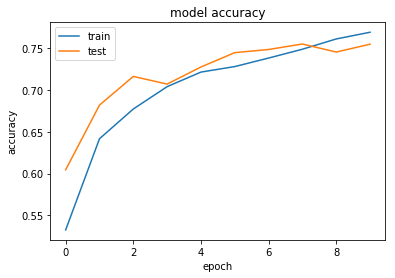

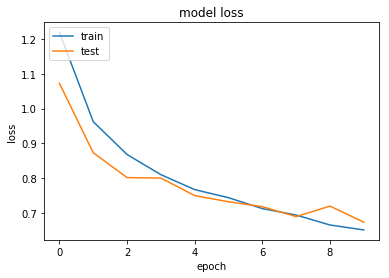

In [13]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
